# Assignment 5

1. You are making 3 versions of your 4th assignment's best model (or pick one from best assignments):
  1. Network with Group Normalization
  2. Network with Layer Normalization
  3. Network with L1 + Batch Normalization

2. You MUST:
  1. Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
  2. Write a single notebook file to run all the 3 models above for 20 epochs each
  3. Create these graphs:
    1. Graph 1: Test/Validation Loss for all 3 models together
    2. Graph 2: Test/Validation Accuracy for 3 models together
    3. Graphs must have proper annotation
3. Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 
4. Write an explanatory README file that explains:
  1. What is your code all about?
  2. How to perform the 3 normalizations techniques that we covered(cannot use values from the excel sheet shared)
  3. Your findings for normalization techniques
  4. Add all your graphs
  5. Your 3 collection of misclassified images 

Upload your complete assignment on GitHub and share the link on LMS

# Install packages

In [83]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Clone the repo with model.py

In [84]:
!rm -rf *.py
!git clone https://github.com/abhyuditjain/eva-8
!mv eva-8/session5/model.py .
!rm -rf eva-8

!cat model.py

Cloning into 'eva-8'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 73 (delta 23), reused 67 (delta 17), pack-reused 0
Unpacking objects: 100% (73/73), 1.60 MiB | 1.78 MiB/s, done.
import torch.nn as nn
import torch.nn.functional as F


def normalizer(method, out_channels):
    if method not in ["BN", "GN", "LN"]:
        raise ValueError("Invalid method of normalization")

    if method == "BN":
        return nn.BatchNorm2d(out_channels)
    elif method == "LN":
        return nn.GroupNorm(1, out_channels)
    else:
        return nn.GroupNorm(5, out_channels)


class Net(nn.Module):
    def __init__(self, normalization_method="BN"):
        """
        Default normalization = batch normalization
        """
        super(Net, self).__init__()
        # Input Block
        self.conv0 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
import numpy as np
from model import *

# Set up transforms

In [86]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Download dataset and apply transforms

In [87]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [88]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

# Model summary

In [90]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Device:', device)

batch_size = 20

model = Net(normalization_method='BN').to(device)
print('\nSummary for BN model')
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

model = Net(normalization_method='LN').to(device)
print('\nSummary for LN model')
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

model = Net(normalization_method='GN').to(device)
print('\nSummary for GN model')
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

Device: cuda

Summary for BN model
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Sequential (conv0)                     --                        [20, 1, 28, 28]           [20, 10, 26, 26]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 1, 28, 28]           [20, 10, 26, 26]          90                        1,216,800                 True
│    └─ReLU (1)                          --                        [20, 10, 26, 26]          [20, 10, 26, 26]          --                        --                        --
│    └─BatchNorm2d (2)                   --                        [20, 10, 26, 26

# Set up training and testing helper functions

In [91]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}
epoch_train_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, normalization_method, regularize_l1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    # L1 Regularization
    if regularize_l1:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    train_losses[normalization_method].append(loss.item())
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[normalization_method].append(100*correct/processed)

    # epoch accuracy = accuracy for the whole batch
  epoch_train_acc[normalization_method].append(100*correct/processed)
  return 100*correct/processed

def test(model, device, test_loader, normalization_method):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[normalization_method].append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[normalization_method].append(100. * correct / len(test_loader.dataset))

# Helper function to show misclassified images

In [92]:
def show_misclassified_images(model, test_loader):
    model.eval()

    misclassified_images = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append({'image': data[i], 'predicted_class': pred[i], 'correct_class': target[i]})

    # Plot the misclassified images
    fig = plt.figure(figsize=(15, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        misclassified_image = misclassified_images[i]
        plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
    plt.tight_layout()
    plt.show()

# **Batch Normalization + L1 Regularization**

In [93]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net(normalization_method='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0)

# Epochs as per assignment = 20
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch, normalization_method='BN', regularize_l1=True) # Regularize L1 = true
    scheduler.step(accuracy)
    test(model, device, test_loader, normalization_method='BN')

EPOCH: 0


LR=0.3 Loss=0.05593567341566086 Batch_id=468 Accuracy=93.65: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Test set: Average loss: 0.0652, Accuracy: 9803/10000 (98.03%)

EPOCH: 1


LR=0.3 Loss=0.08638777583837509 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]


Test set: Average loss: 0.0444, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


LR=0.3 Loss=0.13027139008045197 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]


Test set: Average loss: 0.0388, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


LR=0.3 Loss=0.04352138191461563 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]


Test set: Average loss: 0.0398, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


LR=0.3 Loss=0.05963490530848503 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]


Test set: Average loss: 0.0289, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


LR=0.3 Loss=0.028972411528229713 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]


Test set: Average loss: 0.0311, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


LR=0.3 Loss=0.029599694535136223 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


LR=0.3 Loss=0.09265591949224472 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]


Test set: Average loss: 0.0273, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


LR=0.3 Loss=0.06876637041568756 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]


Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


LR=0.03 Loss=0.10952898859977722 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


LR=0.03 Loss=0.04904142767190933 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


LR=0.03 Loss=0.09033122658729553 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]


Test set: Average loss: 0.0169, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


LR=0.003 Loss=0.0704602375626564 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]


Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


LR=0.00030000000000000003 Loss=0.07420807331800461 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


LR=0.00030000000000000003 Loss=0.03891747444868088 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]


Test set: Average loss: 0.0171, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


LR=3.0000000000000004e-05 Loss=0.026294991374015808 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]


Test set: Average loss: 0.0169, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


LR=3.0000000000000005e-06 Loss=0.036049362272024155 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]


Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


LR=3.000000000000001e-07 Loss=0.04880692437291145 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Test set: Average loss: 0.0168, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


LR=3.000000000000001e-08 Loss=0.09690047800540924 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]


Test set: Average loss: 0.0169, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


LR=3.0000000000000012e-09 Loss=0.06316303461790085 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]


Test set: Average loss: 0.0172, Accuracy: 9939/10000 (99.39%)



In [108]:
print("Minimum training loss = {:.9f}%".format(min(train_losses['BN'])))
print("Minimum testing loss = {:.9f}%".format(min(test_losses['BN'])))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc['BN'])))
print("Best testing accuracy = {:.2f}%".format(max(test_acc['BN'])))

Minimum training loss = 0.022673793%
Minimum testing loss = 0.016716760%
Best training accuracy = 99.26%
Best testing accuracy = 99.46%


### Misclassified images (Batch normalization)

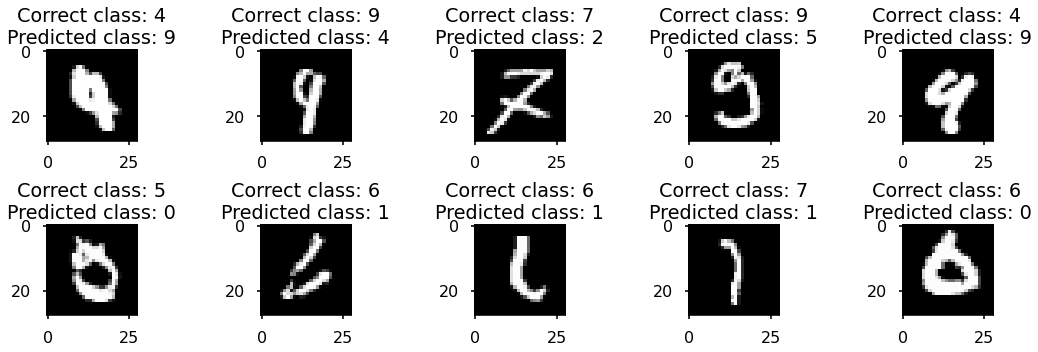

In [94]:
show_misclassified_images(model, test_loader)

# **Layer Normalization**

In [95]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net(normalization_method='LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0)

# Epochs as per assignment = 20
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch, normalization_method='LN')
    scheduler.step(accuracy)
    test(model, device, test_loader, normalization_method='LN')

EPOCH: 0


LR=0.3 Loss=0.19688545167446136 Batch_id=468 Accuracy=80.28: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Test set: Average loss: 0.1544, Accuracy: 9525/10000 (95.25%)

EPOCH: 1


LR=0.3 Loss=0.17611640691757202 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]


Test set: Average loss: 0.0600, Accuracy: 9815/10000 (98.15%)

EPOCH: 2


LR=0.3 Loss=0.009374315850436687 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]


Test set: Average loss: 0.0540, Accuracy: 9810/10000 (98.10%)

EPOCH: 3


LR=0.3 Loss=0.10807996988296509 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]


Test set: Average loss: 0.0458, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


LR=0.3 Loss=0.03563908860087395 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]


Test set: Average loss: 0.0326, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


LR=0.3 Loss=0.04524559900164604 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]


Test set: Average loss: 0.0363, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


LR=0.3 Loss=0.05531574413180351 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]


Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


LR=0.3 Loss=0.02167866937816143 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]


Test set: Average loss: 0.0384, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


LR=0.3 Loss=0.02600870281457901 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]


Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


LR=0.3 Loss=0.1127706989645958 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]


Test set: Average loss: 0.0279, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


LR=0.3 Loss=0.029108522459864616 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]


Test set: Average loss: 0.0298, Accuracy: 9896/10000 (98.96%)

EPOCH: 11


LR=0.03 Loss=0.06603094190359116 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


LR=0.03 Loss=0.007164277136325836 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


LR=0.03 Loss=0.0232885479927063 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


LR=0.03 Loss=0.013080020435154438 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


LR=0.03 Loss=0.027428708970546722 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


LR=0.003 Loss=0.28271302580833435 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]


Test set: Average loss: 0.0169, Accuracy: 9953/10000 (99.53%)

EPOCH: 17


LR=0.00030000000000000003 Loss=0.036543380469083786 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)

EPOCH: 18


LR=0.00030000000000000003 Loss=0.10148144513368607 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]


Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)

EPOCH: 19


LR=3.0000000000000004e-05 Loss=0.02906031906604767 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)



In [109]:
print("Minimum training loss = {:.9f}%".format(min(train_losses['LN'])))
print("Minimum testing loss = {:.9f}%".format(min(test_losses['LN'])))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc['LN'])))
print("Best testing accuracy = {:.2f}%".format(max(test_acc['LN'])))

Minimum training loss = 0.000677945%
Minimum testing loss = 0.016774649%
Best training accuracy = 99.17%
Best testing accuracy = 99.53%


### Misclassified images (Layer normalization)

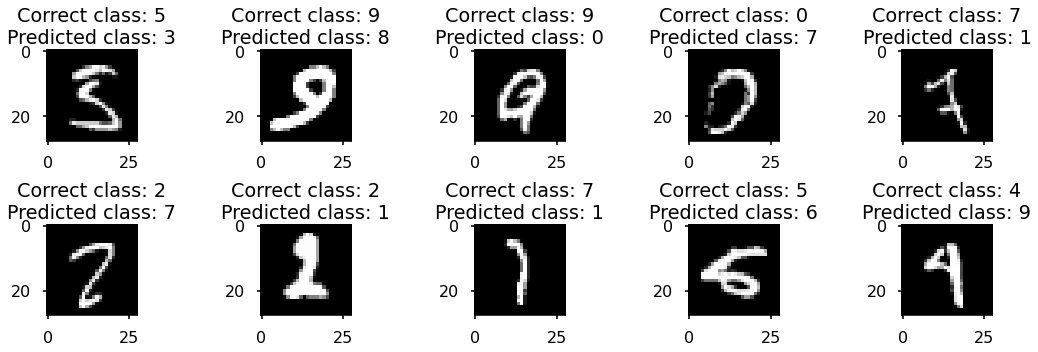

In [96]:
show_misclassified_images(model, test_loader)

# **Group Normalization**

In [97]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net(normalization_method='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0)

# Epochs as per assignment = 20
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch, normalization_method='GN')
    scheduler.step(accuracy)
    test(model, device, test_loader, normalization_method='GN')

EPOCH: 0


LR=0.3 Loss=0.2826511859893799 Batch_id=468 Accuracy=88.61: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]


Test set: Average loss: 0.0949, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


LR=0.3 Loss=0.08116962015628815 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]


Test set: Average loss: 0.0705, Accuracy: 9796/10000 (97.96%)

EPOCH: 2


LR=0.3 Loss=0.21270303428173065 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]


Test set: Average loss: 0.0491, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


LR=0.3 Loss=0.04172547161579132 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]


Test set: Average loss: 0.0515, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


LR=0.3 Loss=0.04826033115386963 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]


Test set: Average loss: 0.0485, Accuracy: 9852/10000 (98.52%)

EPOCH: 5


LR=0.3 Loss=0.12252825498580933 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


Test set: Average loss: 0.0514, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


LR=0.3 Loss=0.04038538783788681 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]


Test set: Average loss: 0.0457, Accuracy: 9866/10000 (98.66%)

EPOCH: 7


LR=0.3 Loss=0.016595682129263878 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]


Test set: Average loss: 0.0374, Accuracy: 9895/10000 (98.95%)

EPOCH: 8


LR=0.3 Loss=0.06871116906404495 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]


Test set: Average loss: 0.0454, Accuracy: 9862/10000 (98.62%)

EPOCH: 9


LR=0.03 Loss=0.05634066462516785 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]


Test set: Average loss: 0.0282, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


LR=0.03 Loss=0.017688659951090813 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]


Test set: Average loss: 0.0273, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


LR=0.03 Loss=0.0370250828564167 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]


Test set: Average loss: 0.0260, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


LR=0.003 Loss=0.031288258731365204 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]


Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


LR=0.003 Loss=0.006914952304214239 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


LR=0.00030000000000000003 Loss=0.01721513457596302 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


LR=3.0000000000000004e-05 Loss=0.01250744890421629 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


LR=3.0000000000000005e-06 Loss=0.04591161385178566 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


LR=3.0000000000000005e-06 Loss=0.05353866517543793 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


LR=3.000000000000001e-07 Loss=0.019719501957297325 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


LR=3.000000000000001e-08 Loss=0.007634031120687723 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)



In [110]:
print("Minimum training loss = {:.9f}%".format(min(train_losses['GN'])))
print("Minimum testing loss = {:.9f}%".format(min(test_losses['GN'])))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc['GN'])))
print("Best testing accuracy = {:.2f}%".format(max(test_acc['GN'])))

Minimum training loss = 0.000926618%
Minimum testing loss = 0.025614110%
Best training accuracy = 99.02%
Best testing accuracy = 99.29%


### Misclassified images (Group normalization)

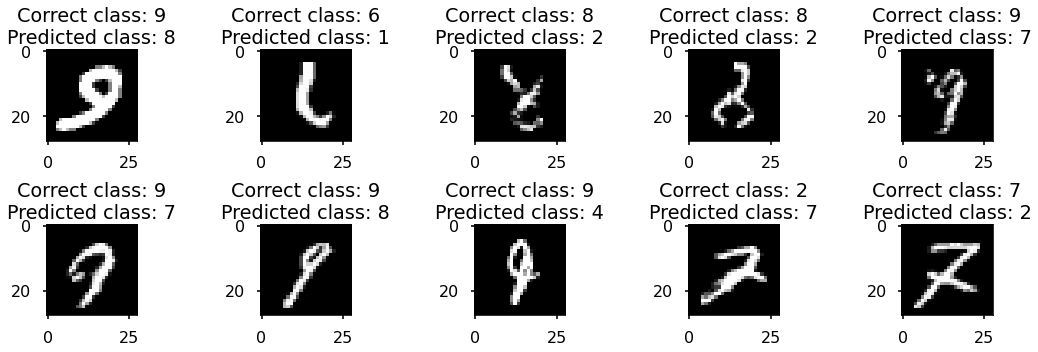

In [98]:
show_misclassified_images(model, test_loader)

# **Graphs**

### Losses

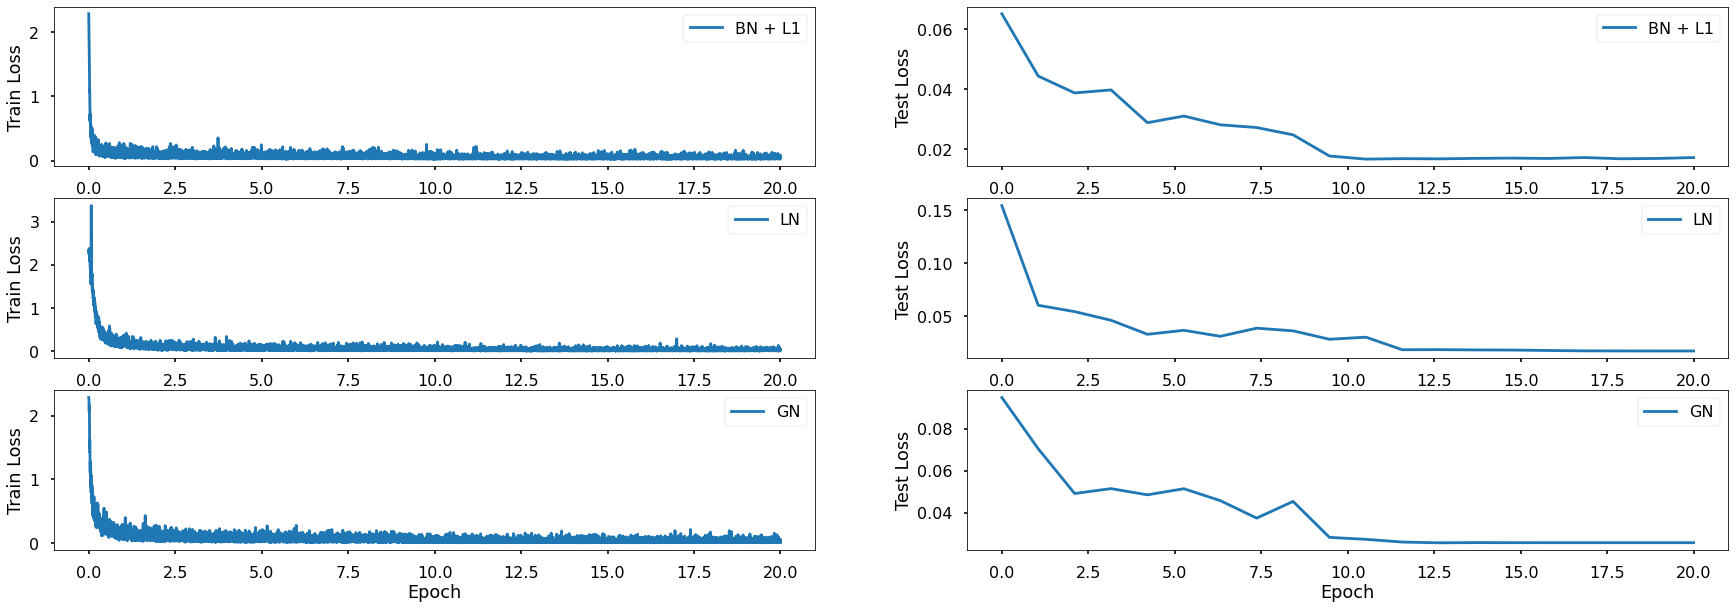

In [107]:
fig, ax = plt.subplots(3, 2)

train_epoch_linspace = np.linspace(0, EPOCHS, len(train_losses['BN']))
test_epoch_linspace = np.linspace(0, EPOCHS, len(test_losses['BN']))

ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Train Loss')
ax[0][0].plot(train_epoch_linspace, train_losses['BN'], label='BN + L1')
ax[0][0].tick_params(axis='y')
ax[0][0].legend(loc='upper right')

ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Test Loss')
ax[0][1].plot(test_epoch_linspace, test_losses['BN'], label='BN + L1')
ax[0][1].tick_params(axis='y')
ax[0][1].legend(loc='upper right')

ax[1][0].set_xlabel('Epoch')
ax[1][0].set_ylabel('Train Loss')
ax[1][0].plot(train_epoch_linspace, train_losses['LN'], label='LN')
ax[1][0].tick_params(axis='y')
ax[1][0].legend(loc='upper right')

ax[1][1].set_xlabel('Epoch')
ax[1][1].set_ylabel('Test Loss')
ax[1][1].plot(test_epoch_linspace, test_losses['LN'], label='LN')
ax[1][1].tick_params(axis='y')
ax[1][1].legend(loc='upper right')

ax[2][0].set_xlabel('Epoch')
ax[2][0].set_ylabel('Train Loss')
ax[2][0].plot(train_epoch_linspace, train_losses['GN'], label='GN')
ax[2][0].tick_params(axis='y')
ax[2][0].legend(loc='upper right')

ax[2][1].set_xlabel('Epoch')
ax[2][1].set_ylabel('Test Loss')
ax[2][1].plot(test_epoch_linspace, test_losses['GN'], label='GN')
ax[2][1].tick_params(axis='y')
ax[2][1].legend(loc='upper right')

fig.set_size_inches(30, 10)
plt.show()

### Accuracies

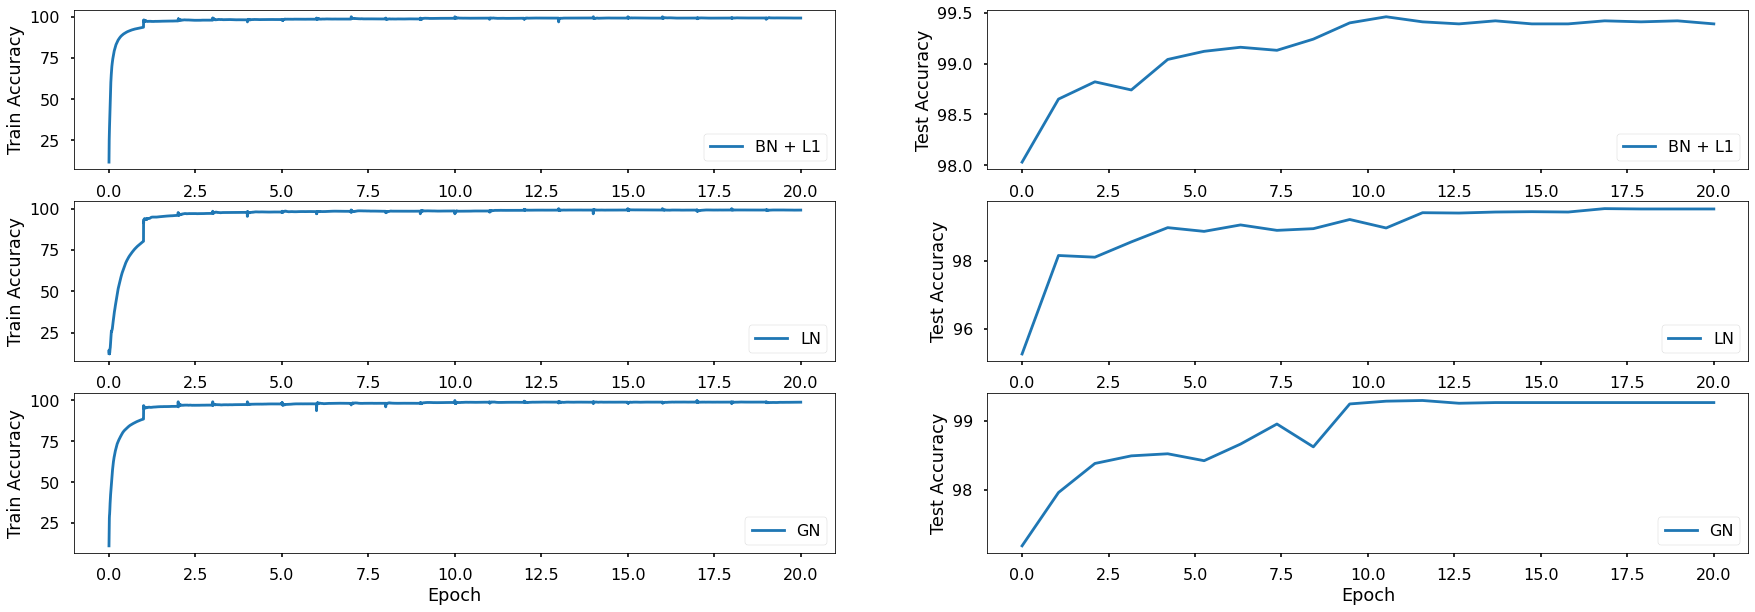

In [106]:
fig, ax = plt.subplots(3, 2)

train_epoch_linspace = np.linspace(0, EPOCHS, len(train_acc['BN']))
test_epoch_linspace = np.linspace(0, EPOCHS, len(test_acc['BN']))

ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Train Accuracy')
ax[0][0].plot(train_epoch_linspace, train_acc['BN'], label='BN + L1')
ax[0][0].tick_params(axis='y')
ax[0][0].legend(loc='lower right')

ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Test Accuracy')
ax[0][1].plot(test_epoch_linspace, test_acc['BN'], label='BN + L1')
ax[0][1].tick_params(axis='y')
ax[0][1].legend(loc='lower right')

ax[1][0].set_xlabel('Epoch')
ax[1][0].set_ylabel('Train Accuracy')
ax[1][0].plot(train_epoch_linspace, train_acc['LN'], label='LN')
ax[1][0].tick_params(axis='y')
ax[1][0].legend(loc='lower right')

ax[1][1].set_xlabel('Epoch')
ax[1][1].set_ylabel('Test Accuracy')
ax[1][1].plot(test_epoch_linspace, test_acc['LN'], label='LN')
ax[1][1].tick_params(axis='y')
ax[1][1].legend(loc='lower right')

ax[2][0].set_xlabel('Epoch')
ax[2][0].set_ylabel('Train Accuracy')
ax[2][0].plot(train_epoch_linspace, train_acc['GN'], label='GN')
ax[2][0].tick_params(axis='y')
ax[2][0].legend(loc='lower right')

ax[2][1].set_xlabel('Epoch')
ax[2][1].set_ylabel('Test Accuracy')
ax[2][1].plot(test_epoch_linspace, test_acc['GN'], label='GN')
ax[2][1].tick_params(axis='y')
ax[2][1].legend(loc='lower right')

fig.set_size_inches(30, 10)
plt.show()